# Data API

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

2023-10-02 14:00:24.069536: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 14:00:24.655375: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 14:00:24.659634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 14:00:26.684192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [21]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [22]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [23]:
dataset1 = dataset.map(lambda x: x * 2)
for item in dataset1:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)


In [24]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


In [27]:
train_filepaths = "/"

filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers
)

In [33]:
X_mean, X_std = [0.] * 8, [1.] * 8
n_inputs = 8

def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [34]:
preprocess(b'4.2083,44.0,5.3232,0.9171,856.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([   4.2083,   44.    ,    5.3232,    0.9171,  856.    ,    2.337 ,
          37.47  , -122.2   ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

In [35]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                      n_read_threads=None, shuffle_buffer_size=10000,
                      n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads
    )
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    return dataset.batch(batch_size).prefetch(1)

# TFRecord

In [36]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [37]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [39]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
# dataset = tf.data.TFRecordDataset(["my_compressed_data.tfrecord"], compression_type="GZIP")

## Tensorflow Protobufs

In [41]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[
                b"a@b.com",
                b"c@d.com"
            ]))
        }
    )
)

In [42]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [43]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string)
}

In [44]:
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)

In [45]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [46]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

# Preprocessing Input Features

In [49]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [50]:
std_layer = Standardization()
# std_layer.adapt(data_sample)

In [51]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype=tf.int64)

In [52]:
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

In [53]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [54]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)

In [55]:
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

In [56]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)

In [60]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.36121976, 0.30981433],
       [0.09398997, 0.57039213],
       [0.70206356, 0.68403876],
       [0.70206356, 0.68403876]], dtype=float32)>

In [61]:
embedding = keras.layers.Embedding(input_dim=len(vocab) + num_oov_buckets,
                                  output_dim=embedding_dim)
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.00970671, -0.049847  ],
       [-0.02178693, -0.01593484],
       [ 0.01413251, -0.00387118],
       [ 0.01413251, -0.00387118]], dtype=float32)>

In [62]:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=7, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories], outputs=[outputs])

# TFDS

In [64]:
import tensorflow_datasets as tfds

dataset = tfds.load(name="mnist")
mnist_train, mnist_test = dataset["train"], dataset["test"]

2023-09-30 20:59:09.487640: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /home/mihnea/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [68]:
mnist_train = mnist_train.shuffle(10000).batch(32)
mnnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [69]:
# OR
dataset = tfds.load(name="mnist", as_supervised=True, batch_size=32)
mnist_train = dataset["train"].prefetch(1)

# Exercises

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[5000:], X_train_full[:5000]
y_train, y_valid = y_train_full[5000:], y_train_full[:5000]

In [7]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [16]:
from tensorflow.train import Example, Feature, Features, Int64List, BytesList

def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label]))
            }))

In [17]:
from contextlib import ExitStack
import os

def write_tfrecords(folder_name, name, dataset, n_shards=10):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    paths = ["{}/{}.tfrecord-{:05d}-of-{:05d}".format(folder_name, name, index, n_shards)
            for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                  for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [19]:
train_filepaths = write_tfrecords("fashion_mnist", "fashion_mnist.train", train_set)
test_filepaths = write_tfrecords("fashion_mnist", "fashion_mnist.test", test_set)
valid_filepaths = write_tfrecords("fashion_mnist", "fashion_mnist.valid", valid_set)

2023-10-01 15:34:01.393702: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-10-01 15:34:21.869595: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-10-01 15:34:25.341673: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [21]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, [28, 28])
    return image, example["label"]

In [22]:
def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                 n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    
    if cache:
        dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [23]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=50000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

In [24]:
train_set.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

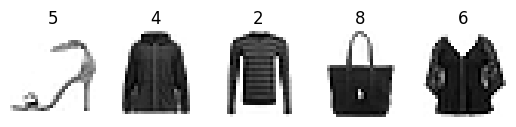

In [30]:
import matplotlib.pyplot as plt

for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(y[i].numpy())

In [31]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
        
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [32]:
standardization = Standardization(input_shape=[28, 28])

In [38]:
sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
             optimizer="nadam", metrics=["accuracy"])

In [39]:
from datetime import datetime

logs = os.path.join(os.curdir, "fashion_mnist_logs", "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = keras.callbacks.TensorBoard(
                log_dir=logs, histogram_freq=1, profile_batch=10
                )

model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[tensorboard_cb])

Epoch 1/5


2023-10-01 16:48:50.137756: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-10-01 16:48:50.137813: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-10-01 16:48:50.137849: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2023-10-01 16:48:50.137861: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2023-10-01 16:48:50.137870: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2023-10-01 16:48:50.137878: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1723] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2023-10-01 16:48:50.138111: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session te

     42/Unknown - 2s 5ms/step - loss: 1.1225 - accuracy: 0.6347

2023-10-01 16:48:52.056660: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-10-01 16:48:52.056743: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-10-01 16:48:52.056764: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2023-10-01 16:48:52.056770: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2023-10-01 16:48:52.056774: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2023-10-01 16:48:52.056779: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1723] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2023-10-01 16:48:52.062956: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session col

1719/1719 [==============================] - 8s 4ms/step - loss: 0.4651 - accuracy: 0.8423 - val_loss: 0.4190 - val_accuracy: 0.8710
Epoch 2/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3397 - accuracy: 0.8792 - val_loss: 0.5964 - val_accuracy: 0.8714
Epoch 3/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3141 - accuracy: 0.8925 - val_loss: 0.4712 - val_accuracy: 0.8812
Epoch 4/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2827 - accuracy: 0.8999 - val_loss: 0.3985 - val_accuracy: 0.8766
Epoch 5/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2526 - accuracy: 0.9070 - val_loss: 0.3623 - val_accuracy: 0.8880


In [40]:
%load_ext tensorboard
%tensorboard --logdir=./fashion_mnist_logs --port=6006

# 10

In [2]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

PosixPath('/home/mihnea/.keras/datasets/aclImdb')

In [3]:
def review_paths(dirpath):
     return[str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

In [4]:
np.random.shuffle(test_valid_pos)

In [5]:
test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

In [6]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath, 'r') as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices((tf.constant(reviews), tf.constant(labels)))

In [7]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b'A previous reviewer said the movie is not all that bad. What?!?!?! The movie glorifies child molestation. Oh, but Sylvia Kristel was naked in it, so let\'s give it 5 out of 10 stars. Why not a full 10? Because the filmography was "agonizing," the child\'s looks of shock were "unrealistic," and the fat friend was "irritating." Nowhere in the review does the reviewer express any outrage that an American movie in 1981 featured scenes of a child having sex with a grown woman. I happened to catch this steaming loaf of a movie while staying at a hotel that had Showtime. To me, even if the fat friend had acted up a storm and was a deserving of an Oscar, I would still have to give the movie only 1 star. That TV\'s Howard Hessman starred in the movie at the same time as he was appearing in WKRP is particularly ridiculous. But don\'t take my word for it!', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b"I can't believe that in the 34 prior comments, nobody me

2023-10-02 14:01:09.486365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-02 14:01:09.509655: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative, num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    
    dataset_pos = tf.data.TextLineDataset(filepaths_positive, num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    
    return tf.data.Dataset.concatenate(dataset_neg, dataset_pos)

In [9]:
batch_size = 32

train_set = imdb_dataset(train_neg, train_pos).shuffle(25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_neg, valid_pos).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_neg, test_pos).batch(batch_size).prefetch(1)

In [10]:
def preprocess(X_batch, n_words=50):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

In [11]:
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word in counter.most_common(max_size)]

In [12]:
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets
        
    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

In [14]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, label: review).take(1)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()), axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets, input_shape=[])
text_vectorization.adapt(sample_reviews)

ValueError: Can't convert Python sequence with mixed types to Tensor.